In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import rand, randn, choice, permutation
from scipy.linalg import hadamard

import torch
import torch.nn.functional as F

import tensorly as tl
from tensorly import decomposition
from tensorly.decomposition import parafac
from scipy import linalg

In [2]:
%run KZTIHT_Functions.ipynb
%run "Adaptive Row Removal Functions.ipynb"
%run Optimising_Trimming.ipynb

In [3]:
np.random.seed(9)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']

In [4]:
cols = []
itr = 100
num_samples = 40
n = 3375
n_dim = [15,15,15]
m = 1050
num_high_search = [10,20,30,40,50,60,70,80]

rank_choices = [[2,2,2],[3,3,3],[4,4,4]]
data_array = np.zeros((num_samples, itr, 2, len(rank_choices)))

for i in range(len(rank_choices)):
    
    r = rank_choices[i]
    #print(i)
    median_data, num_high = plot_trim_HOSVD_fs(r,m,n_dim,num_high = num_high_search)
    
    for samples in range(num_samples):
        
        #print(samples)
        X = random_low_rank_HOSVD(n_dim,r)
        x = vectorize_np(X)
        A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
        A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
        A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
        A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
        A = A_4.T
        b = A@x 
        
        y_KZIHT, error_KZIHT = KZIHT_HOSVD_RR(A,b,X,n,r,gamma = 1, itr = itr)
        y_ATIHT, error_ATIHT = adaptive_TIHT(A,b,X,r,lamda = 1/m,mu = 1,itr=itr, numb_high = num_high)
        #y_IHT_2,error_IHT_2 = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = itr)

        data_array[samples,:, 0,i] = error_ATIHT
        data_array[samples,:, 1,i] = error_KZIHT

### Getting plot data from this 

median_data = np.zeros((itr, len(rank_choices)))
qlow_data = np.zeros((itr, len(rank_choices)))
qup_data = np.zeros((itr, len(rank_choices)))
median_data_kz = np.zeros((itr, len(rank_choices)))
qlow_data_kz = np.zeros((itr, len(rank_choices)))
qup_data_kz = np.zeros((itr, len(rank_choices)))

for i in range(len(rank_choices)):
    
    median_data[:, i] = np.median(data_array[:,:, 0, i],axis = 0)
    qlow_data[:,i] = np.quantile(data_array[:,:, 0, i],q = 0.25, axis = 0)
    qup_data[:,i] = np.quantile(data_array[:,:, 0, i],q = 0.75, axis = 0)
    median_data_kz[:,i] = np.median(data_array[:,:, 1, i],axis = 0)
    qlow_data_kz[:,i] = np.quantile(data_array[:,:, 1, i], q = 0.25, axis = 0)
    qup_data_kz[:,i] = np.quantile(data_array[:,:, 1, i], q = 0.75, axis = 0)

In [5]:
pd.DataFrame(median_data).to_csv('fsmedian_data_tiht.csv')
pd.DataFrame(qlow_data).to_csv('fsqlow_data_tiht.csv')
pd.DataFrame(qup_data).to_csv('fsqup_data_tiht.csv')
pd.DataFrame(median_data_kz).to_csv('fsmedian_data_kztiht.csv')
pd.DataFrame(qlow_data_kz).to_csv('fsqlow_data_kztiht.csv')
pd.DataFrame(qup_data_kz).to_csv('fsqup_data_kztiht.csv')

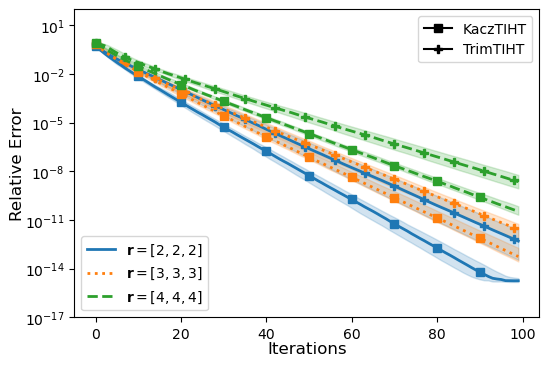

In [6]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots(1,1,figsize=(6,4))
linewidth = [2,2,2]
linestyle = ['-','dotted','dashed']

for i in range(len(rank_choices)):
    mean = median_data[:,i]
    qlow = qlow_data[:,i]
    qhigh = qup_data[:,i]
    plt.plot(range(itr),mean, color  = colors[i], label = "TrimTIHT r="+str(rank_choices[i]), linestyle = linestyle[i], marker = 'P',markevery = 7, linewidth = linewidth[i])
    plt.fill_between(range(itr),qhigh,qlow,alpha=0.2, color  = colors[i])

for i in range(len(rank_choices)):
    mean = median_data_kz[:,i]
    qlow = qlow_data_kz[:,i]
    qhigh = qup_data_kz[:,i]
    plt.plot(range(itr),mean, color  = colors[i], label = "KaczTIHT r="+str(rank_choices[i]),linestyle = linestyle[i], marker = 's', markevery=10, linewidth = linewidth[i])
    plt.fill_between(range(itr),qlow,qhigh,alpha=0.2, color  = colors[i])

custom_lines = [Line2D([0], [0], color=colors[0], linewidth = 2, linestyle = '-'),
                Line2D([0], [0], color=colors[1],linewidth = 2,linestyle = 'dotted'),Line2D([0], [0], color=colors[2],linewidth =2, linestyle = 'dashed')]
legend_1 = plt.legend(custom_lines, [r'$\bf{r}$' +  r'$ = [2,2,2]$', r'$\bf{r}$' +  r'$ = [3,3,3]$',r'$\bf{r}$' +  r'$ = [4,4,4]$'], fontsize='medium', loc = 'lower left')

custom_lines_2 = [Line2D([0], [0], color='black',marker = 's'),Line2D([0], [0], color='black',marker = 'P')]
plt.gca().add_artist(legend_1)

plt.legend(custom_lines_2, ['KaczTIHT','TrimTIHT'], fontsize='medium', loc = 'upper right')

plt.yscale("log")
plt.ylim([1e-17, 10**2]) 

plt.xlabel(xlabel=r'Iterations',labelpad = 0, fontsize = '12')
plt.ylabel(ylabel=r'Relative Error',labelpad = 0, fontsize = '12')
#plt.grid()
plt.show()
fig.savefig('fsTrimTIHTvsKaczTIHT.png', dpi=300,  bbox_inches="tight")

In [7]:
#####################
### CP Rank #########
#####################

In [8]:
np.random.seed(9)
cols = []
itr = 100
num_samples = 40
n = 3375
n_dim = [15,15,15]
m = 1500
num_high_search = [10,20,40,60,80]

rank_choices = [2,3,4]
data_array = np.zeros((num_samples, itr, 2, len(rank_choices)))

for i in range(len(rank_choices)):
    
    r = rank_choices[i]
    #print(i)
    median_data, num_high = plot_trim_CP_fs(r,m,n_dim,num_high = num_high_search)
    
    for samples in range(num_samples):
        
        #print(samples)
        X = random_low_rank_CP(n_dim,r)
        x = vectorize_np(X)
        A_1 = np.random.normal(0.0,1.0,(n_dim[0],m))
        A_2 = np.random.normal(0.0,1.0,(n_dim[1],m))
        A_3 = np.random.normal(0.0,1.0,(n_dim[2],m))
        A_4 = linalg.khatri_rao(A_1,linalg.khatri_rao(A_2,A_3))
        A = A_4.T
        b = A@x 
        
        y_KZIHT, error_KZIHT = KZIHT_CP_RR(A,b,X,n,r,gamma = 1, itr = itr)
        y_ATIHT, error_ATIHT = adaptive_TIHT_CP(A,b,X,r,lamda = 1/m,mu = 1,itr=itr, numb_high = num_high)
        #y_IHT_2,error_IHT_2 = TIHT_HOSVD(A,b,X,r,lamda=1/m,itr = itr)

        data_array[samples,:, 0,i] = error_ATIHT
        data_array[samples,:, 1,i] = error_KZIHT

### Getting plot data from this 

median_data = np.zeros((itr, len(rank_choices)))
qlow_data = np.zeros((itr, len(rank_choices)))
qup_data = np.zeros((itr, len(rank_choices)))
median_data_kz = np.zeros((itr, len(rank_choices)))
qlow_data_kz = np.zeros((itr, len(rank_choices)))
qup_data_kz = np.zeros((itr, len(rank_choices)))

for i in range(len(rank_choices)):
    
    median_data[:, i] = np.median(data_array[:,:, 0, i],axis = 0)
    qlow_data[:,i] = np.quantile(data_array[:,:, 0, i],q = 0.25, axis = 0)
    qup_data[:,i] = np.quantile(data_array[:,:, 0, i],q = 0.75, axis = 0)
    median_data_kz[:,i] = np.median(data_array[:,:, 1, i],axis = 0)
    qlow_data_kz[:,i] = np.quantile(data_array[:,:, 1, i], q = 0.25, axis = 0)
    qup_data_kz[:,i] = np.quantile(data_array[:,:, 1, i], q = 0.75, axis = 0)

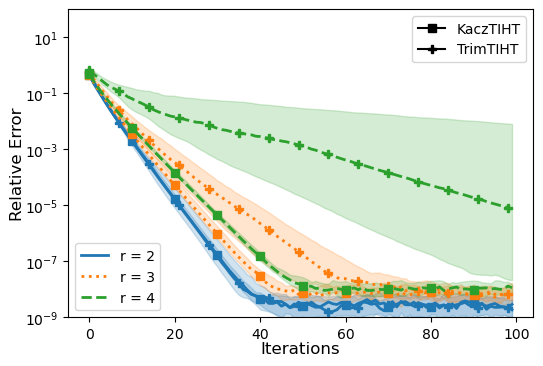

In [9]:
from matplotlib.lines import Line2D
fig,ax = plt.subplots(1,1,figsize=(6,4))
linewidth = [2,2,2]
linestyle = ['-','dotted','dashed']

for i in range(len(rank_choices)):
    mean = median_data[:,i]
    qlow = qlow_data[:,i]
    qhigh = qup_data[:,i]
    plt.plot(range(itr),mean, color  = colors[i], label = "TrimTIHT r="+str(rank_choices[i]), linestyle = linestyle[i], marker = 'P',markevery = 7, linewidth = linewidth[i])
    plt.fill_between(range(itr),qhigh,qlow,alpha=0.2, color  = colors[i])

for i in range(len(rank_choices)):
    mean = median_data_kz[:,i]
    qlow = qlow_data_kz[:,i]
    qhigh = qup_data_kz[:,i]
    plt.plot(range(itr),mean, color  = colors[i], label = "KaczTIHT r="+str(rank_choices[i]),linestyle = linestyle[i], marker = 's', markevery=10, linewidth = linewidth[i])
    plt.fill_between(range(itr),qlow,qhigh,alpha=0.2, color  = colors[i])

custom_lines = [Line2D([0], [0], color=colors[0], linewidth = 2, linestyle = '-'),
                Line2D([0], [0], color=colors[1],linewidth = 2,linestyle = 'dotted'),Line2D([0], [0], color=colors[2],linewidth =2, linestyle = 'dashed')]
legend_1 = plt.legend(custom_lines, ['r = 2', 'r = 3','r = 4'], fontsize='medium', loc = 'lower left')

custom_lines_2 = [Line2D([0], [0], color='black',marker = 's'),Line2D([0], [0], color='black',marker = 'P')]
plt.gca().add_artist(legend_1)

plt.legend(custom_lines_2, ['KaczTIHT','TrimTIHT'], fontsize='medium', loc = 'upper right')

plt.yscale("log")
plt.ylim([1e-9, 10**2]) 

plt.xlabel(xlabel=r'Iterations',labelpad = 0, fontsize = '12')
plt.ylabel(ylabel=r'Relative Error',labelpad = 0, fontsize = '12')
#plt.grid()
plt.show()
fig.savefig('fsTrimTIHTvsKaczTIHT_CP.png', dpi=300,  bbox_inches="tight")